In [129]:
#seach for organic tweets and save them in one list
from collections import Counter
import csv
tweets=[]
positive_tweets = 0
negative_tweets = 0
other_tweets = 0

with open( 'D:\AllSamples.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        if row['sent']=='P':
            positive_tweets += 1
        elif row['sent']=='N':
            negative_tweets += 1
        else:
            other_tweets += 1
        
        tweets.append(row) 
print 'We have', len(tweets), 'sampled tweets'
print positive_tweets, 'are positive'
print negative_tweets, 'are negative'
print other_tweets, 'are nothing'

We have 2000 sampled tweets
676 are positive
275 are negative
1049 are nothing


In [130]:
# Create label vector (y) and print its stats.
from collections import Counter
import numpy as np
y = np.array([t['sent'] for t in tweets])
print 'label counts=', Counter(y)


label counts= Counter({'O': 1049, 'P': 676, 'N': 275})


Populating the interactive namespace from numpy and matplotlib


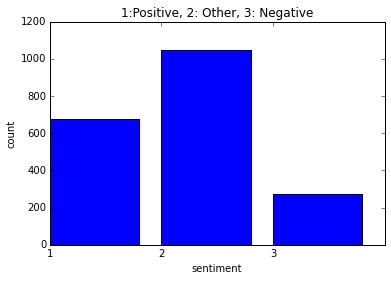

In [131]:
%pylab inline
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(y).values()
vals = [1,2,3]

plt.bar(vals, counts)
plt.xticks(vals)
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title('1:Positive, 2: Other, 3: Negative')
plt.show()

In [132]:
import re

def tokenize(string, lowercase, keep_punctuation, prefix,
             collapse_urls, collapse_mentions):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    if prefix:
        tokens = ['%s%s' % (prefix, t) for t in tokens]
    return tokens

def tweet2tokens(tweet, lowercase=True,keep_punctuation=True,collapse_urls=True, collapse_mentions=True):
    tokens = tokenize(tweet['text'], lowercase, keep_punctuation, None,collapse_urls, collapse_mentions)
    return tokens


In [133]:
# Let's tokenize all tweets.
tokens_list = [tweet2tokens(t, lowercase=True,keep_punctuation=False,collapse_urls=True, collapse_mentions=True) for t in tweets]

In [134]:
tokens_list[1]

['THIS_IS_A_MENTION',
 'anything',
 'that',
 'attracts',
 'people',
 'away',
 'from',
 'tobacco',
 'cigarettes',
 'is',
 'a',
 'good',
 'thing',
 'inc',
 'ecig',
 'flavours',
 'euecigban']

In [135]:
for t in range(len(tokens_list)):
    print tokens_list[t]
    break

['vaping', 'kush', 'gt', 'smoking', 'kush']


In [136]:
for t in tweets:
    print t['text']
    break

Vaping kush&gt;Smoking kush


In [170]:
'Way to use tokenized tokens or use default tokenization with my own modifications'
'Right each detail in report format'
'create a schedule to follow'
'project CSP571 - social unrest, weather and mood -  maybe use this to publish other articles....'


'Right each detail in report format'

In [167]:
#use after pre processing 
# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore')# CountVectorizer(decode_error='ignore',lowercase =False)
X = vectorizer.fit_transform(t['text'] for t in tweets)
print 'default - vectorized %d tweets. found %d terms.' % (X.shape[0], X.shape[1])

default - vectorized 2000 tweets. found 7370 terms.


In [138]:
#use after pre processing 
# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=False)
X = vectorizer.fit_transform(t['text'] for t in tweets)
print 'no lower case vectorized %d tweets. found %d terms.' % (X.shape[0], X.shape[1])

no lower case vectorized 2000 tweets. found 8439 terms.


In [139]:
#use after pre processing 
# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, stop_words='english')# CountVectorizer(decode_error='ignore',lowercase =False)
X = vectorizer.fit_transform(t['text'] for t in tweets)
print 'lower case, stop words - vectorized %d tweets. found %d terms.' % (X.shape[0], X.shape[1])

lower case, stop words - vectorized 2000 tweets. found 7140 terms.


In [140]:
print vectorizer.vocabulary_.items()[:10]

[(u'yffvsl6y9a', 7034), (u'todays', 6276), (u'rrihhjzh', 5372), (u'taggwyhi', 6066), (u'nottingham', 4483), (u'hanging', 2872), (u'tweetiatrician', 6417), (u'boningmugger', 976), (u'3m', 160), (u'increase', 3170)]


In [141]:
# What are the most frequent terms?
# Sum columns:
col_sums = X.sum(axis=0).tolist()[0]
# Sort sums in descending order, and return the indices.
top_indices = np.argsort(col_sums)[::-1]
print 'top_indices=', top_indices
vocab = np.array(vectorizer.get_feature_names())
top_terms = vocab[top_indices]
print 'top_terms:\n', '\n'.join('%s %d' % (term, count) for term, count in zip(top_terms, top_indices)[:10])

top_indices= [3061 5378 1368 ..., 5074 2254 6492]
top_terms:
http 3061
rt 5378
cigarettes 1368
cigarette 1364
cig 1357
electronic 2154
ecig 2052
smoke 5721
smoking 5737
vaping 6610


In [147]:
# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model.predict(X)
print 'accuracy on training data=%.3f' % accuracy(y, predicted)

accuracy on training data=0.805


In [148]:
# Fit a LogisticRegression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [151]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv(X, y, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(), X, y, cv=cv))
  
print do_cv(X, y)

0.687


In [152]:
# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 5)
accuracies = []
print 'Fitting in the labeled data:'
#print 'Train set:',X[train_ind].shape[0], '\f Test set:', X[test_ind].shape[0]
for train_ind, test_ind in cv:
    model.fit(X[train_ind], y[train_ind])
    
    predictions = model.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.2f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

Fitting in the labeled data:
Average 5-fold cross validation accuracy=0.68 (std=0.03)


In [156]:
# This time, we'll use sklearn's built in tokenization.
from sklearn.feature_extraction.text import TfidfVectorizer
def tokenize(tweets, vectorizer):
    X = vectorizer.fit_transform(t['text'] for t in tweets)
    print 'X dimensions=', X.shape
    return X

X = tokenize(tweets, TfidfVectorizer(decode_error='ignore', lowercase=True, stop_words='english'))

X dimensions= (2000, 7140)


(1, 1)
X dimensions= (2000, 1877)
(1, 2)
X dimensions= (2000, 3098)
(2, 2)
X dimensions= (2000, 1221)
(1, 3)
X dimensions= (2000, 3797)
(2, 3)
X dimensions= (2000, 1920)
(3, 3)
X dimensions= (2000, 699)


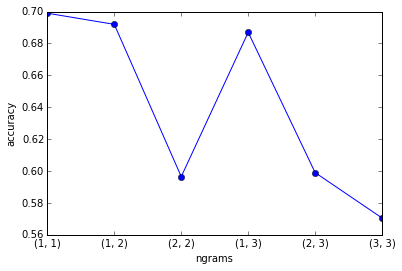

In [159]:
# How does using ngrams help?
import matplotlib.pyplot as plt

def compare_ngrams(tweets, y):
    accuracies = []
    ngrams = [(1,1), (1,2), (2,2), (1,3), (2, 3), (3,3)]
    for ngram in ngrams:
        print ngram
        accuracies.append(do_cv(tokenize(tweets, TfidfVectorizer(decode_error='ignore', lowercase=True, stop_words='english',min_df=2, ngram_range=ngram)), y))
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks(range(len(ngrams)), ngrams)
    plt.xlabel('ngrams')
    plt.ylabel('accuracy')
    plt.show()
        
compare_ngrams(tweets, y)

In [106]:
# What are the top weighted features?

# Get the learned coefficients for the Positive class.
coef = model.coef_[2]
# Sort them in descending order.
top_coef_ind = np.argsort(coef)[::-1]
# Get the names of those features.
top_coef_terms = vocab[top_coef_ind]
# Get the weights of those features
top_coef = coef[top_coef_ind]
# Print the top 10.
print 'top weighted terms for positive class:\n', \
    '\n'.join('%s %.2f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10])

top weighted terms for positive class:
vaping 3.07
ecig 2.69
cig 2.41
vape 2.06
need 1.50
got 1.48
green 1.40
good 1.39
want 1.18
electric 1.18


In [143]:
# Get the learned coefficients for the Negative class.
coef = model.coef_[0]
# Sort them in descending order.
top_coef_ind = np.argsort(coef)[::-1]
# Get the names of those features.
top_coef_terms = vocab[top_coef_ind]
# Get the weights of those features
top_coef = coef[top_coef_ind]
# Print the top 10.
print 'top weighted terms for negative class:\n', \
    '\n'.join('%s %.2f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10])

top weighted terms for negative class:
stupid 1.57
sorry 1.28
smokes 1.27
he 1.22
pussy 1.22
shit 1.15
class 1.14
faggot 1.14
one 1.13
look 1.11


In [111]:
# Get the learned coefficients for the OTHER class.
coef = model.coef_[1]
# Sort them in descending order.
top_coef_ind = np.argsort(coef)[::-1]
# Get the names of those features.
top_coef_terms = vocab[top_coef_ind]
# Get the weights of those features
top_coef = coef[top_coef_ind]
# Print the top 10.
print 'top weighted terms for negative class:\n', \
    '\n'.join('%s %.2f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10])

top weighted terms for negative class:
http 6.25
cigarettes 1.28
retail 1.28
vaper_trail_ 1.18
smokers 1.06
la 1.01
10 1.00
dallas 1.00
ni 0.99
stores 0.96


In [165]:
'Idea: Sample tweets that don\'t have the label ' 

"Idea: Sample tweets that don't have the label "

In [97]:
#sampling tweets for testing
import csv
import random
tweets_test=[]
with open( 'D:/ecig.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    #chances_selected = desired_num_results / total_entries
    chances_selected = 2000

    for row in reader:
        if random.random() < 0.3:
            tweets_test.append(row) 

In [98]:
print len(tweets_test) ,'tweets were sampled for testing'
print tweets_test[1]['sent']

1393742 tweets were sampled for testing
None


In [99]:
#saving sampled test tweets
import csv
with open( 'D:/training.csv','wb') as train:
    writer = csv.DictWriter(train, fieldnames=['country_code', 'flag', 'followers_count', 'friends_count', 'hashtag', 'id', 'is_retweet',
 'klout_score', 'link', 'location_coord_type', 'location_coords', 'location_displayname', 'location_type', 'media_display_url', 'media_type',
 'media_url', 'posted_time', 'real_name', 'rule_match', 'source', 'statuses_count', 'text', 'title', 'tweet_url', 'user_bio_summary',
 'user_location', 'user_mention', 'user_mention_username', 'user_twitter_page', 'username', 'shorttime', 'week', 'hand_label', 'svm', 'mdy',
 '_merge','sent'])
    writer.writeheader()
    for row in tweets_test:
        writer.writerow(row)   
train.close()  

In [100]:
#reading tweets from disk - test tweets
import csv
import random
tweets_train=[]
with open( 'D:/training.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        tweets_train.append(row) 

In [105]:
print tweets_train[1]


{'week': '', 'user_twitter_page': 'http://www.twitter.com/pizzzatimes', 'media_display_url': '', 'text': 'nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4', 'mdy': '19267', 'country_code': '', 'tweet_url': '', 'id': 'tag:search.twitter.com,2005:252558775297376257', '_merge': '3', 'title': 'nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4', 'hand_label': 'N/A', 'user_location': 'Lawnguy Land', 'source': 'Tumblr', 'followers_count': '22', 'klout_score': '22', 'user_mention_username': '', 'location_coords': '', 'user_mention': '', 'shorttime': '', 'media_type': '', 'sent': '', 'is_retweet': '.', 'username': 'pizzzatimes', 'location_displayname': '', 'statuses_count': '8825', 'friends_count': '9', 'flag': '', 'svm': '-', 'link': 'http://twitter.com/pizzzatimes/statuses/252558775297376257', 'location_coord_type': '', 'hashtag': '', 'location_type': '', 'user_bio_summary': 'http://pizzzatime.tumblr.com', 'real_name': 'Steven Barry', '

In [107]:
#use after pre processing 
# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, stop_words='english')# CountVectorizer(decode_error='ignore',lowercase =False)
XX = vectorizer.fit_transform(t['text'] for t in tweets_train)
print 'lower case, stop words - vectorized %d tweets. found %d terms.' % (XX.shape[0], XX.shape[1])

lower case, stop words - vectorized 1393742 tweets. found 415958 terms.


In [171]:
just predict
plot tweets per day classified as positive and negative

SyntaxError: invalid syntax (<ipython-input-171-3024f2a358c5>, line 1)